In [1]:
#Vizualize demand spatial distribution in Amsterdam emoped pilot

In [18]:
### Imports 
import os
import math
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as patches
import json

import pandas as pd
import re
import xml.etree.ElementTree as ET

sys.path.append('../../')
from script.conversion.bison.coordinates import rd_to_utm
from mnms.graph.layers import PublicTransportLayer, MultiLayerGraph, OriginDestinationLayer
from mnms.generation.roads import generate_pt_line_road, generate_one_zone
from mnms.generation.layers import generate_bbox_origin_destination_layer
from mnms.vehicles.veh_type import Tram, Metro, Bus
from mnms.generation.zones import generate_one_zone
from mnms.mobility_service.public_transport import PublicTransportMobilityService
from mnms.time import TimeTable, Dt, Time
from mnms.io.graph import load_graph, save_graph, save_odlayer
from mnms.tools.render import draw_roads, draw_line, draw_odlayer
from mnms.tools.geometry import points_in_polygon, get_bounding_box


In [28]:
### Parameters

# Files and directories
current_dir = os.getcwd()
indir = current_dir + '/inputs/'
outdir = current_dir + '/outputs/'
f = open('params.json')
params = json.load(f)

amsterdam_json_filepath = indir + params['fn_network'] # mlgraph with the road network only
ams_dmd_path = indir + 'test_all_in_highway_7h_9h.csv' # dmd inside ringroad 7-9am

In [29]:
### Get the MLGraph without TCs 
amsterdam_graph = load_graph(amsterdam_json_filepath)
roads = amsterdam_graph.roads

In [30]:
# Load dmd
db_dmd = pd.read_csv(ams_dmd_path, sep=';')

In [31]:
db_dmd

,ID,DEPARTURE,ORIGIN,DESTINATION
0,1168071,07:00:00,634180.9360684787 5801629.541588004,625022.1658398311 5803258.391749226
1,1040303,07:00:02,626592.2832221197 5802782.201807101,627119.3937449739 5802857.838660972
2,1034483,07:00:04,627345.0816454801 5804263.484180098,634180.9360684787 5801629.541588004
3,985601,07:00:05,634180.9360684787 5801629.541588004,628408.4006607257 5802607.606304967
4,396330,07:00:09,634180.9360684787 5801629.541588004,629039.4545156191 5804289.138790642
...,...,...,...,...
9405,1050286,08:59:56,626124.6513297992 5802432.080601969,634180.9360684787 5801629.541588004
9406,1106874,08:59:56,632778.5268014283 5803575.269459474,634180.9360684787 5801629.541588004
9407,1120808,08:59:57,634180.9360684787 5801629.541588004,634037.5281292694 5800649.76836723
9408,1089329,08:59:58,627184.6443263115 5799024.982075843,626527.037702565 5799611.930337115


In [32]:
nb_dmd = len(db_dmd)
origins = np.zeros((len(db_dmd),2))
destinations = np.zeros((len(db_dmd),2))
for i, row in db_dmd[:].iterrows():
    origins[i] = [float(o) for o in row['ORIGIN'].split(' ')]
    destinations[i] = [float(d) for d in row['DESTINATION'].split(' ')]

In [33]:
# Create clusters of OD
from sklearn.cluster import KMeans

In [34]:
all_od = np.zeros((2*nb_dmd,2))
all_od[:nb_dmd] = origins
all_od[nb_dmd:] = destinations

nb_clusters = 200

kmeans = KMeans(n_clusters = nb_clusters, random_state=0).fit([[x,y] for (x,y) in all_od])#, sample_weight=df_centroids['weight'].values)\n",





/Users/louis/opt/anaconda3/envs/mnms/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [35]:
od_clustered = kmeans.cluster_centers_

(5795000.0, 5812500.0)

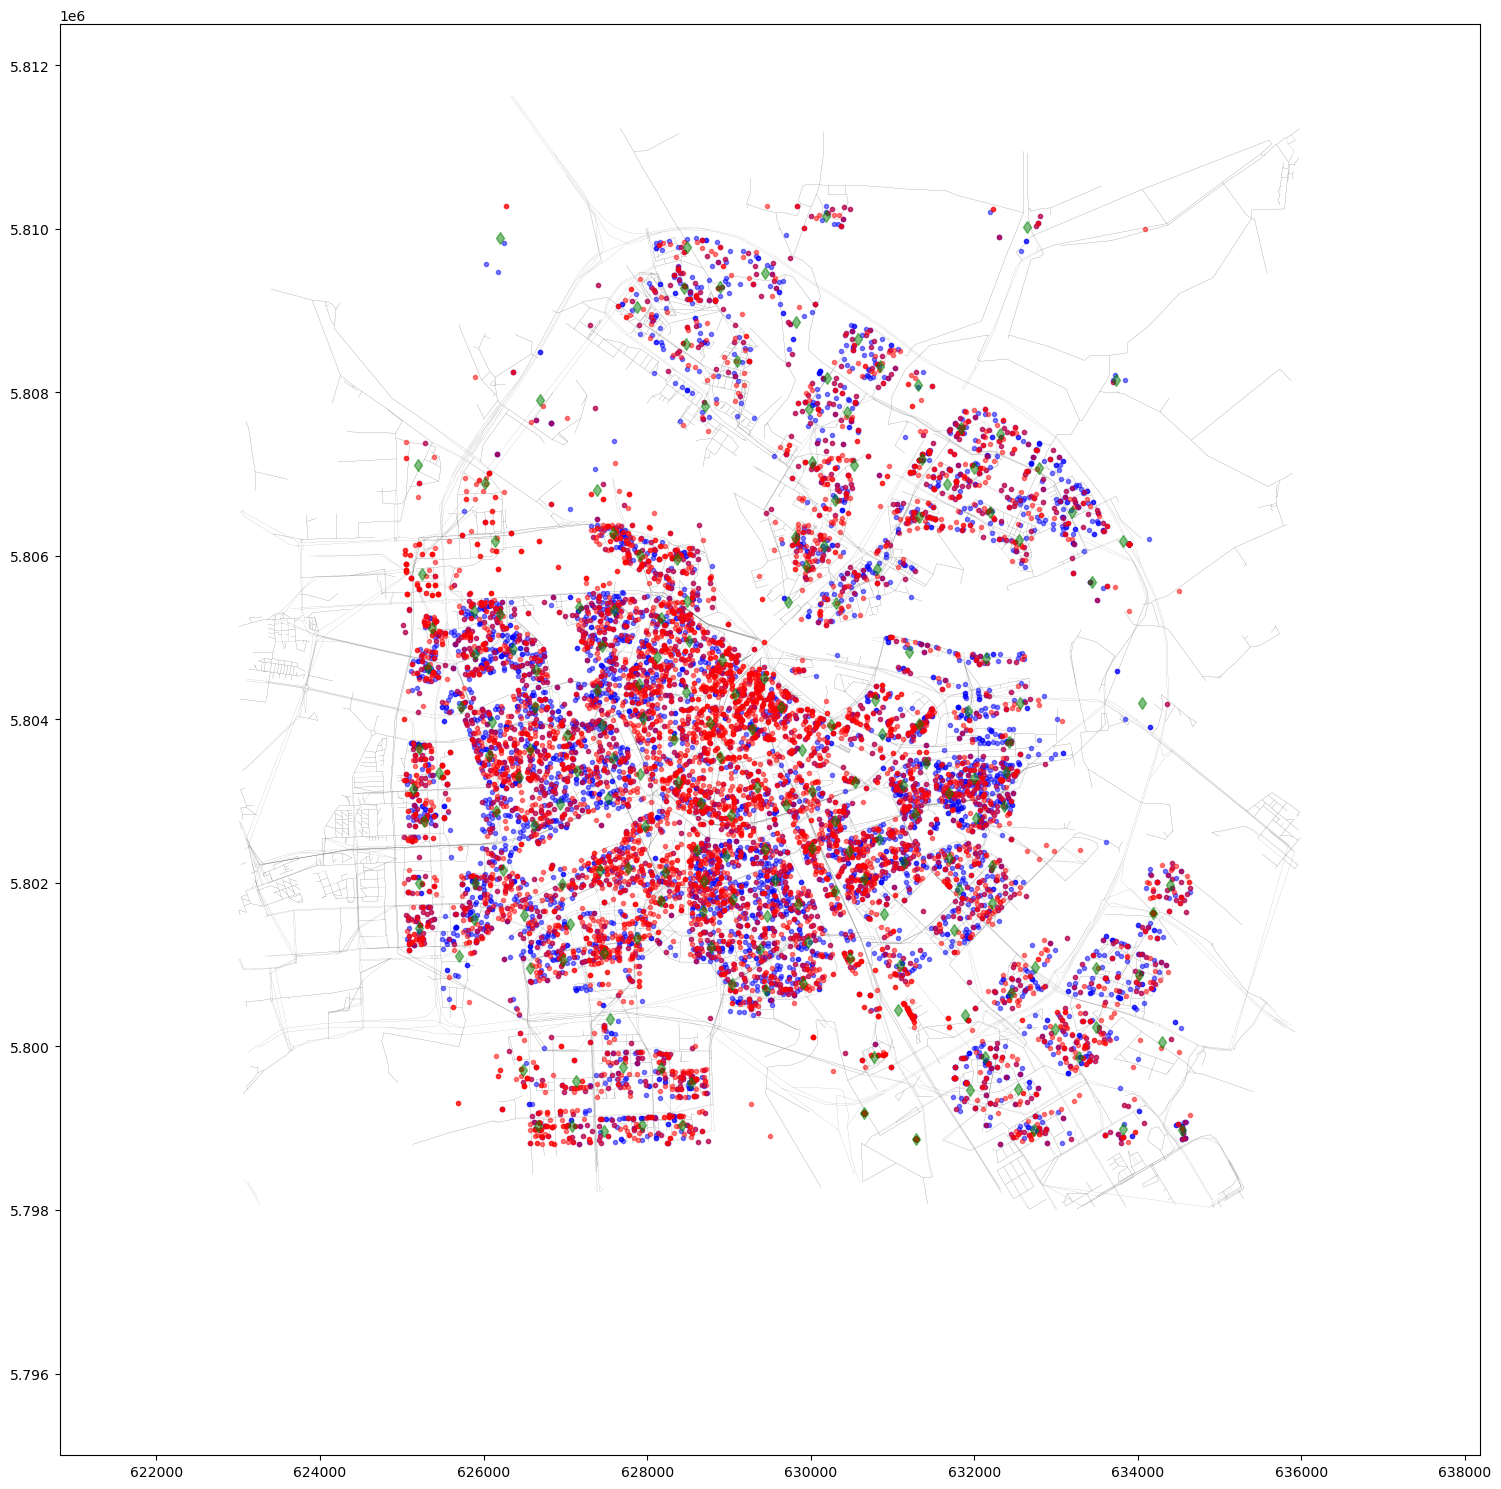

In [36]:
fig, ax = plt.subplots(figsize=(15, 15))
draw_roads(ax, roads, color='grey', linkwidth=0.1, nodesize=0, draw_stops=False, node_label=False)

plt.plot(origins[:,0], origins[:,1], 'b.', alpha=0.5)
plt.plot(destinations[:,0], destinations[:,1], 'r.', alpha=0.5)
plt.plot(od_clustered[:,0], od_clustered[:,1], 'gd', alpha=0.5)
plt.xlim([624e3, 635e3])
plt.ylim([5.795e6, 5.8125e6])

In [37]:
# Save odlayer
odlayer = OriginDestinationLayer()

for i, od in enumerate(od_clustered):
    odlayer.create_origin_node(f"ORIGIN_{i}", od)
    odlayer.create_destination_node(f"DESTINATION_{i}", od)

In [38]:
odlayer.origins

{'ORIGIN_0': array([ 625213.89405275, 5801993.66067854]),
 'ORIGIN_1': array([ 631754.16180506, 5801424.98852937]),
 'ORIGIN_2': array([ 630532.68341296, 5807104.35363438]),
 'ORIGIN_3': array([ 634180.88591992, 5801628.67127334]),
 'ORIGIN_4': array([ 626632.04120738, 5804149.31103477]),
 'ORIGIN_5': array([ 627877.84065266, 5801324.9692053 ]),
 'ORIGIN_6': array([ 630247.2837475, 5803926.7992795]),
 'ORIGIN_7': array([ 628916.87649009, 5804720.95014039]),
 'ORIGIN_8': array([ 628474.54335023, 5808588.78116583]),
 'ORIGIN_9': array([ 633193.53403034, 5806539.78051878]),
 'ORIGIN_10': array([ 633278.10416878, 5799872.62712063]),
 'ORIGIN_11': array([ 629563.50945491, 5802037.63385462]),
 'ORIGIN_12': array([ 631999.81465816, 5803277.75668353]),
 'ORIGIN_13': array([ 625320.1363161 , 5804629.96783572]),
 'ORIGIN_14': array([ 627080.26246611, 5799030.94477954]),
 'ORIGIN_15': array([ 628427.49630427, 5799033.71181566]),
 'ORIGIN_16': array([ 627913.42497072, 5806002.98558313]),
 'ORIGIN_

In [14]:
#save_odlayer(odlayer, indir + f'od_layer_clustered_{nb_clusters}.json')

NameError: name 'df_' is not defined